In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

In [3]:
lal.G_SI, lal.C_SI, 1.0e6*lal.PC_SI, lal.MSUN_SI

(6.67384e-11, 299792458.0, 3.085677581491367e+22, 1.9885469549614615e+30)

In [4]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

In [5]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.6.0
HDF5    1.8.13
Python  2.7.12 (default, Oct 11 2016, 14:42:58) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]
sys.platform    darwin
sys.maxsize     9223372036854775807
numpy   1.12.0b1



In [6]:
sys.path.insert(0, '../cbcrom')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb
import timeseriesutils as tsutils

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)
imp.reload(tsutils)

<module 'timeseriesutils' from '../cbcrom/timeseriesutils.pyc'>

In [7]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Load Python version of ROM

In [8]:
memb_size=2**26-1

# Bamp_filename = '../data/Bamp_cheb_3_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_3_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_3.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_3.hdf5'

# Bamp_filename = '../data/Bamp_cheb_9_%d.hdf5'
# Bphase_filename = '../data/Bphase_cheb_9_%d.hdf5'
# ampcoeff_filename = '../data/amp_coeffs_cheb_9.hdf5'
# phasecoeff_filename = '../data/phase_coeffs_cheb_9.hdf5'

Bamp_filename = '../data/Bamp_cheb_16_%d.hdf5'
Bphase_filename = '../data/Bphase_cheb_16_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs_cheb_16.hdf5'
phasecoeff_filename = '../data/phase_coeffs_cheb_16.hdf5'

rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [9]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

In [61]:
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 1.35, 1.35, 2000.0, 2000.0
hp0, hc0 = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

# Check that lalsuite version exists and produces waveform

In [25]:
pycbc.waveform.td_approximants()

['TaylorEt',
 'SEOBNRv3_opt',
 'IMRPhenomA',
 'IMRPhenomC',
 'IMRPhenomB',
 'EOBNRv2',
 'SEOBNRv4_opt',
 'PhenSpinTaylor',
 'PhenSpinTaylorRD',
 'NR_hdf5',
 'TEOBResum_ROM',
 'SEOBNRv3_pert',
 'EOBNRv2HM',
 'SpinTaylorT4',
 'TaylorT1',
 'TaylorT3',
 'TaylorT2',
 'HGimri',
 'TaylorT4',
 'IMRPhenomD',
 'IMRPhenomPv2',
 'SEOBNRv1',
 'SpinDominatedWf',
 'SEOBNRv3',
 'SEOBNRv2',
 'SpinTaylorT1',
 'SEOBNRv4',
 'SpinTaylorT2',
 'EccentricTD',
 'SEOBNRv2_opt',
 'SEOBNRv3_opt_rk4']

In [26]:
phiRef=0.0
deltaT=1./2**14
fLow=50.0
fRef=50.0
distance=100.0e6*lal.PC_SI
inclination=0.0
m1SI=1.35*lal.MSUN_SI
m2SI=1.35*lal.MSUN_SI
lambda1=2000.0
lambda2=2000.0
hp1, hc1 = lalsimulation.SimInspiralTEOBResumROM(phiRef,deltaT,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)
hp2, hc2 = lalsimulation.SimInspiralTEOBResumROM(phiRef,deltaT,fLow,fRef,distance,inclination,m1SI,m2SI,lambda1,lambda2)

# Extract data from lalsimulation's structures
tstart = hp1.epoch.gpsSeconds+hp1.epoch.gpsNanoSeconds*1.0e-9
times = tstart + hp1.deltaT*np.arange(hp1.data.length)

(-0.1, 0.01)

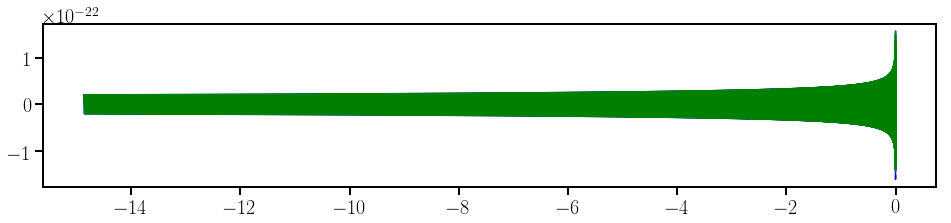

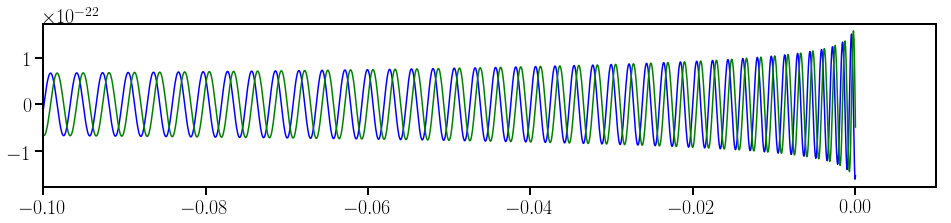

In [27]:
fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data)
axes.plot(times, hc1.data.data)

fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data)
axes.plot(times, hc1.data.data)
axes.set_xlim(-0.100, 0.010)

In [37]:
def choose_td_waveform(m1, m2, lambda1, lambda2, distance, inclination, f_min, delta_t):
    """The lalsimulation.SimInspiralChooseTDWaveform version.
    """
    f_ref = 0.
    phiRef = 0.
    
    # Must have aligned spin
    s1x, s1y, s1z, s2x, s2y, s2z = 0., 0., 0., 0., 0., 0.
    
    # Eccentricity is not part of the model
    longAscNodes = 0.
    eccentricity = 0.
    meanPerAno = 0.
    
    approximant = 'TEOBResum_ROM'
    lal_approx = lalsimulation.GetApproximantFromString(approximant)
    lal_params = lal.CreateDict()
    
    # Insert tidal parameters into dictionary
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda1(lal_params, lambda1)
    lalsimulation.SimInspiralWaveformParamsInsertTidalLambda2(lal_params, lambda2)
    
    # Evaluate waveform
    hp, hc = lalsimulation.SimInspiralChooseTDWaveform(
                            m1*lal.MSUN_SI, m2*lal.MSUN_SI, 
                            s1x, s1y, s1z, s2x, s2y, s2z, 
                            distance*1.0e6*lal.PC_SI,
                            inclination, phiRef, longAscNodes, eccentricity, meanPerAno, 
                            delta_t, f_min, f_ref, lal_params, lal_approx)
    
    # Extract data from lalsimulation's structures
    tstart = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds*1.0e-9
    ts = tstart + hp.deltaT*np.arange(hp.data.length)
    
    return ts, hp, hc

In [49]:
f_min = 50.0
delta_t = 1.0/2**14
distance, inclination = 100.0, 0.0
m1, m2 = 1.35, 1.35
lambda1, lambda2 = 2000.0, 2000.0
times3, hp3, hc3 = choose_td_waveform(m1, m2, lambda1, lambda2, distance, inclination, f_min, delta_t)

(-0.05, 0.005)

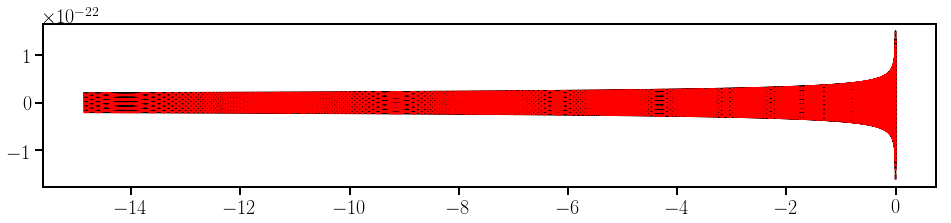

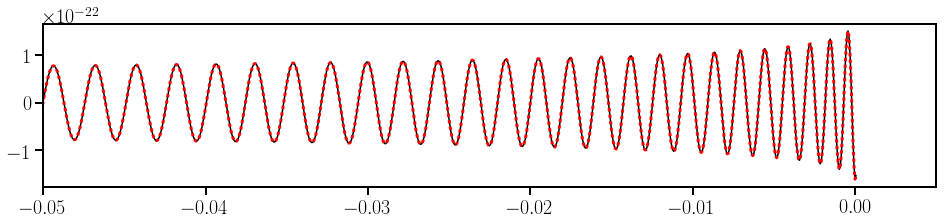

In [53]:
fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data, c='k')
axes.plot(times3, hp3.data.data, ls=':', c='r')

fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data, c='k')
axes.plot(times3, hp3.data.data, ls=':', c='r', lw=3)
axes.set_xlim(-0.050, 0.005)

# Check that pycbc version exists and produces waveform

In [56]:
approximant = 'TEOBResum_ROM'
#approximant = 'TaylorT4'
f_sample = 2**14
f_lower = 50.0

delta_t = 1.0/f_sample
distance, inclination = 100.0, 0.0
mass1, mass2 = 1.35, 1.35

lambda1, lambda2 = 2000.0, 2000.0
    
hp4, hc4 = pycbc.waveform.get_td_waveform(approximant=approximant,
            mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
            distance=distance, inclination=inclination,
            delta_t=delta_t, f_lower=f_lower)

In [58]:
np.array(hp4.sample_times)

array([ -1.48647460e+01,  -1.48646850e+01,  -1.48646240e+01, ...,
        -6.09674063e-05,   6.77499994e-08,   6.11029062e-05])

(-0.05, 0.005)

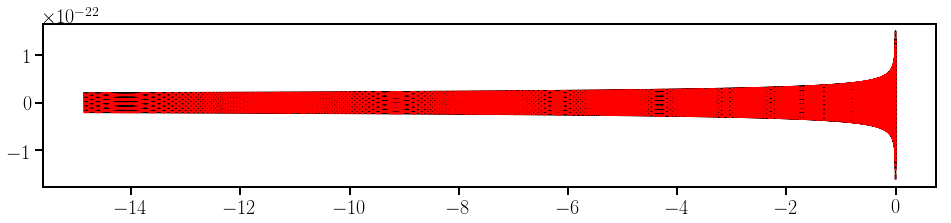

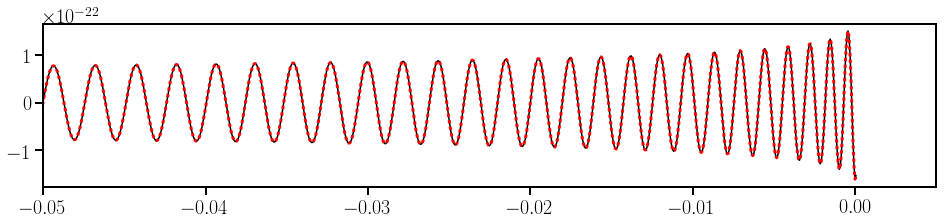

In [59]:
fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data, c='k')
axes.plot(np.array(hp4.sample_times), np.array(hp4), ls=':', c='r')

fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hp1.data.data, c='k')
axes.plot(np.array(hp4.sample_times), np.array(hp4), ls=':', c='r', lw=3)
axes.set_xlim(-0.050, 0.005)

(-0.05, 0.005)

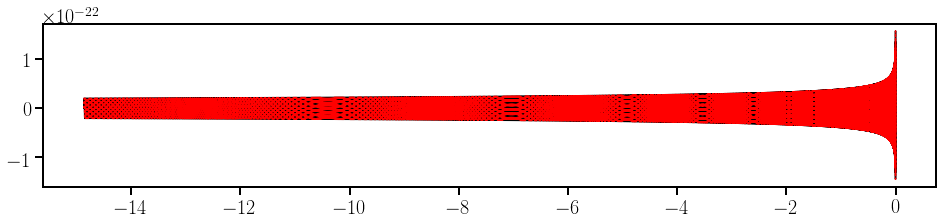

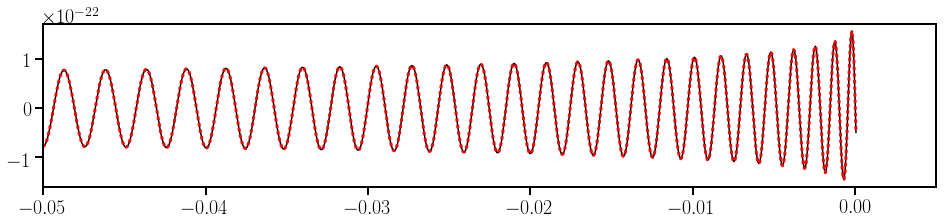

In [60]:
fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hc1.data.data, c='k')
axes.plot(np.array(hc4.sample_times), np.array(hc4), ls=':', c='r')

fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(times, hc1.data.data, c='k')
axes.plot(np.array(hc4.sample_times), np.array(hc4), ls=':', c='r', lw=3)
axes.set_xlim(-0.050, 0.005)

# Compare original python version to pycbc (which calls lalsuite)

(-0.05, 0.005)

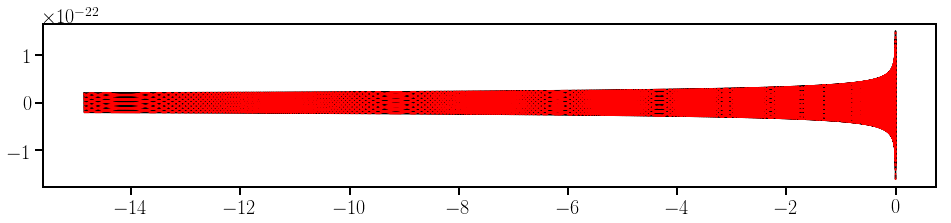

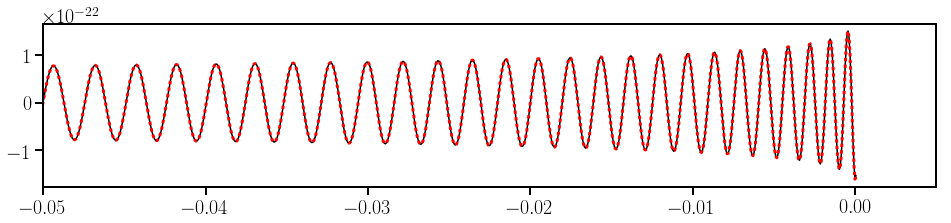

In [62]:
fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(np.array(hp0.sample_times), np.array(hp0), c='k')
axes.plot(np.array(hp4.sample_times), np.array(hp4), ls=':', c='r')

fig, axes = plt.subplots(figsize=(16, 3))
axes.plot(np.array(hp0.sample_times), np.array(hp0), c='k')
axes.plot(np.array(hp4.sample_times), np.array(hp4), ls=':', c='r', lw=3)
axes.set_xlim(-0.050, 0.005)